# Sentinel Devices - Anomaly Detection Project

ISYE / CSE / MGT 6748

Student: Tung Nguyen, tnguyen844@gatech.edu

## Model Inference

This notebook was run on: Python 3.13, macOS 15 Sequoia, Macbook Pro (M1 Max).

This notebook provides an example of how model inference would work.

For a more production-ready setup, refer to files in `/04-app`.

In [5]:
from typing import List
from dotenv import load_dotenv

import os
import logging
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langchain_core.documents.base import Document
from utils import (
    query_anomalies,
    query_analog_sensor_importances,
    query_digital_sensor_activations,
    update_analog_sensor_plot_for_user,
    update_digital_sensor_plot_for_user
)

logging.basicConfig(level=logging.INFO)

load_dotenv(r'../.env');
print('OPENAI_API_KEY' in os.environ)

True


## LLM Logic

### Initialization

In [6]:
# Load Vector DB
embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

vector_db = Chroma(
    collection_name='train_metadata',
    persist_directory=r'./02-data/chroma_db',
    embedding_function=embeddings
)

# Initialize LLM
tools = [
    query_anomalies,
    query_analog_sensor_importances,
    query_digital_sensor_activations,
    update_analog_sensor_plot_for_user,
    update_digital_sensor_plot_for_user
]
llm = ChatOpenAI(model='gpt-4o').bind_tools(tools, parallel_tool_calls=True)

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


### Main System Prompt

In [7]:
sys_msg = SystemMessage(content="""
    You are a helpful analyst tasked with aiding users understand anomaly detection data.
                        
    Users are non-technical and responses should be clear, concise, and jargon-free.
    
    The data comes from a train that is monitored by 8 analog sensors and 8 digital sensors. 
    The analog sensors are: tp2, tp3, h1, dv_pressure, reservoirs, oil_temperature, flowmeter, motor_current
    The digital sensors are: comp, dv_electric, towers, mpg, lps, pressure_switch, oil_level, caudal_impulses
    
    Sensors record data once per second from 6AM to 2AM the next day each day.
                        
    The user will ask you questions about anomalies that the system has detected. 
    You have access to tools that can help you answer the user's questions. These tools include:
    1. query_anomalies(start_ts: str, end_ts: str) -> Returns a list of anomalies between start_ts and end_ts.
    2. query_analog_sensor_importances(start_ts: str, end_ts: str) -> Returns a dictionary of sensor importances (in seconds out of range) between start_ts and end_ts.
    3. query_digital_sensor_activations(start_ts: str, end_ts: str) -> Returns a dictionary of digital sensor activations (in seconds activated) between start_ts and end_ts.
    4. update_analog_sensor_plot_for_user(sensor_name: str, start_ts: str, end_ts: str) -> Plots analog sensor data for the user.
    5. update_digital_sensor_plot_for_user(sensor_name: str, start_ts: str, end_ts: str) -> Plots digital sensor data for the user.
                        
    start_ts and end_ts must be between 2022-01-01 and 2022-06-02 and be in 'YYYY-MM-DD HH:MM:SS' (24H - Military Time) format.
    
    When plotting anomaly events, make sure to always plot 3 hours before and after the event to provide context.
    
    There is also only space for one plot at a time, do not try to plot multiple sensors at once.

    The underlying anomaly detection model works by fitting 1 Prophet Forecasting Model per analog sensor.
    For each timestamp, if >5 analog sensors are out of their expected range for >5 minutes, then the timestamp is flagged as an anomaly.
    Digital sensors are not used in the anomaly detection model, but may be useful for understanding anomalies.
    
    Use these tools to gather data and generate plots to help the user understand the anomalies.
""")

### Build LangGraph

In [ ]:
def _write_context_to_file(message: HumanMessage, context: List[Document]) -> None:
    with open(r'./output/context.log', r'a') as f:
        f.write(f'Prompt ID: {message.id}\n')
        f.write(f'Prompt: {message.content}\n\n')
        f.write(f'Retrieved: {len(context)}, Sample (Top-1):\n')
        f.write(f'{context[0].page_content}\n\n\n')
    return None

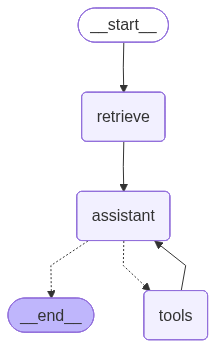

In [9]:
# Custom State
class ContextState(MessagesState):
    context: str

# RAG Component 
def retrieve(state: ContextState):
    """Retrieval Augmented Generation (RAG) - Retrieves relevant documents from Vector DB
    based on the latest user prompt and appends them to the conversation history.
    """
    prompt = state['messages'][-1].content
    retrieved_docs = vector_db.similarity_search(prompt, k = 4)
    _write_context_to_file(state['messages'][-1], retrieved_docs)
    return {'context': retrieved_docs}

# Generation Component
def assistant(state: ContextState):
    context_msg = SystemMessage(content=f"""
    The following context was retrieved from the knowledge base to help you answer the user's question:
    {r'\n\n'.join([doc.page_content for doc in state['context']])}
    """)
    return {'messages': [llm.invoke([sys_msg] + [context_msg] + state['messages'])]}

# Build Graph
builder = StateGraph(ContextState)

builder.add_node('retrieve', retrieve)
builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'retrieve')
builder.add_edge('retrieve', 'assistant')
builder.add_conditional_edges(
    'assistant',
    tools_condition,
)
builder.add_edge('tools', 'assistant')

# In-Memory Checkpointer for Demo
memory = MemorySaver()
llm_graph = builder.compile(checkpointer=memory)

# Display Graph
display(Image(llm_graph.get_graph(xray=True).draw_mermaid_png()))

## Chatbot Demo

In [ ]:
config = {'configurable': {'thread_id': '1'}}

# Reset Context Log
if os.path.exists(r'./output/context.log'):
    os.remove(r'./output/context.log')

messages = [HumanMessage(content='Were there any anomalies in February?')]
messages = llm_graph.invoke({'messages': messages}, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [11]:
for m in messages['messages']:
    m.pretty_print()
    print()

================================ Human Message =================================

Were there any anomalies in February?

================================== Ai Message ==================================
Tool Calls:
  query_anomalies (call_na7COwIha4vv4kgAojl85W3j)
 Call ID: call_na7COwIha4vv4kgAojl85W3j
  Args:
    start_ts: 2022-02-01 06:00:00
    end_ts: 2022-02-28 02:00:00

================================= Tool Message =================================
Name: query_anomalies

[{"event_id": 576, "anomaly_start_ts": "2022-02-27 08:53:55", "anomaly_end_ts": "2022-02-27 09:02:06", "event_duration_in_secs": 492}]

================================== Ai Message ==================================

Yes, there was an anomaly detected in February. It occurred on February 27th and lasted roughly 8 minutes, from 08:53:55 to 09:02:06. Would you like more detailed information about this anomaly?



In [12]:
messages = [HumanMessage(content='Yes. Please provide details.')]
messages = llm_graph.invoke({'messages': messages}, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [13]:
for m in messages['messages'][-5:]:
    m.pretty_print()
    print()

================================ Human Message =================================

Yes. Please provide details.

================================== Ai Message ==================================
Tool Calls:
  query_analog_sensor_importances (call_vau7X3WIqDjPaWQmtqhN8ZRx)
 Call ID: call_vau7X3WIqDjPaWQmtqhN8ZRx
  Args:
    start_ts: 2022-02-27 08:53:55
    end_ts: 2022-02-27 09:02:06
  query_digital_sensor_activations (call_UvFHDlNDsyV1oeGrLNwd8Iu8)
 Call ID: call_UvFHDlNDsyV1oeGrLNwd8Iu8
  Args:
    start_ts: 2022-02-27 08:53:55
    end_ts: 2022-02-27 09:02:06

================================= Tool Message =================================
Name: query_analog_sensor_importances

{"tp2_pred": 301, "tp3_pred": 399, "h1_pred": 491, "dv_pressure_pred": 1, "reservoirs_pred": 488, "oil_temperature_pred": 396, "flowmeter_pred": 479, "motor_current_pred": 489}

================================= Tool Message =================================
Name: query_digital_sensor_activations

{"comp": 2, "d

In [14]:
messages = [HumanMessage(content='Can you show me what oil temperature looks like around the anomaly period?')]
messages = llm_graph.invoke({'messages': messages}, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [16]:
for m in messages['messages'][-4:]:
    m.pretty_print()
    print()

================================ Human Message =================================

Can you show me what oil temperature looks like around the anomaly period?

================================== Ai Message ==================================
Tool Calls:
  update_analog_sensor_plot_for_user (call_2IdPSrti2VOiJV2HbUr0Iei2)
 Call ID: call_2IdPSrti2VOiJV2HbUr0Iei2
  Args:
    sensor_name: oil_temperature
    start_ts: 2022-02-27 05:53:55
    end_ts: 2022-02-27 12:02:06

================================= Tool Message =================================
Name: update_analog_sensor_plot_for_user

null

================================== Ai Message ==================================

I've plotted the oil temperature data around the time of the anomaly on February 27th. You can now examine how the sensor behaved before, during, and after the anomaly period. If you have any further questions or need additional information, feel free to ask!



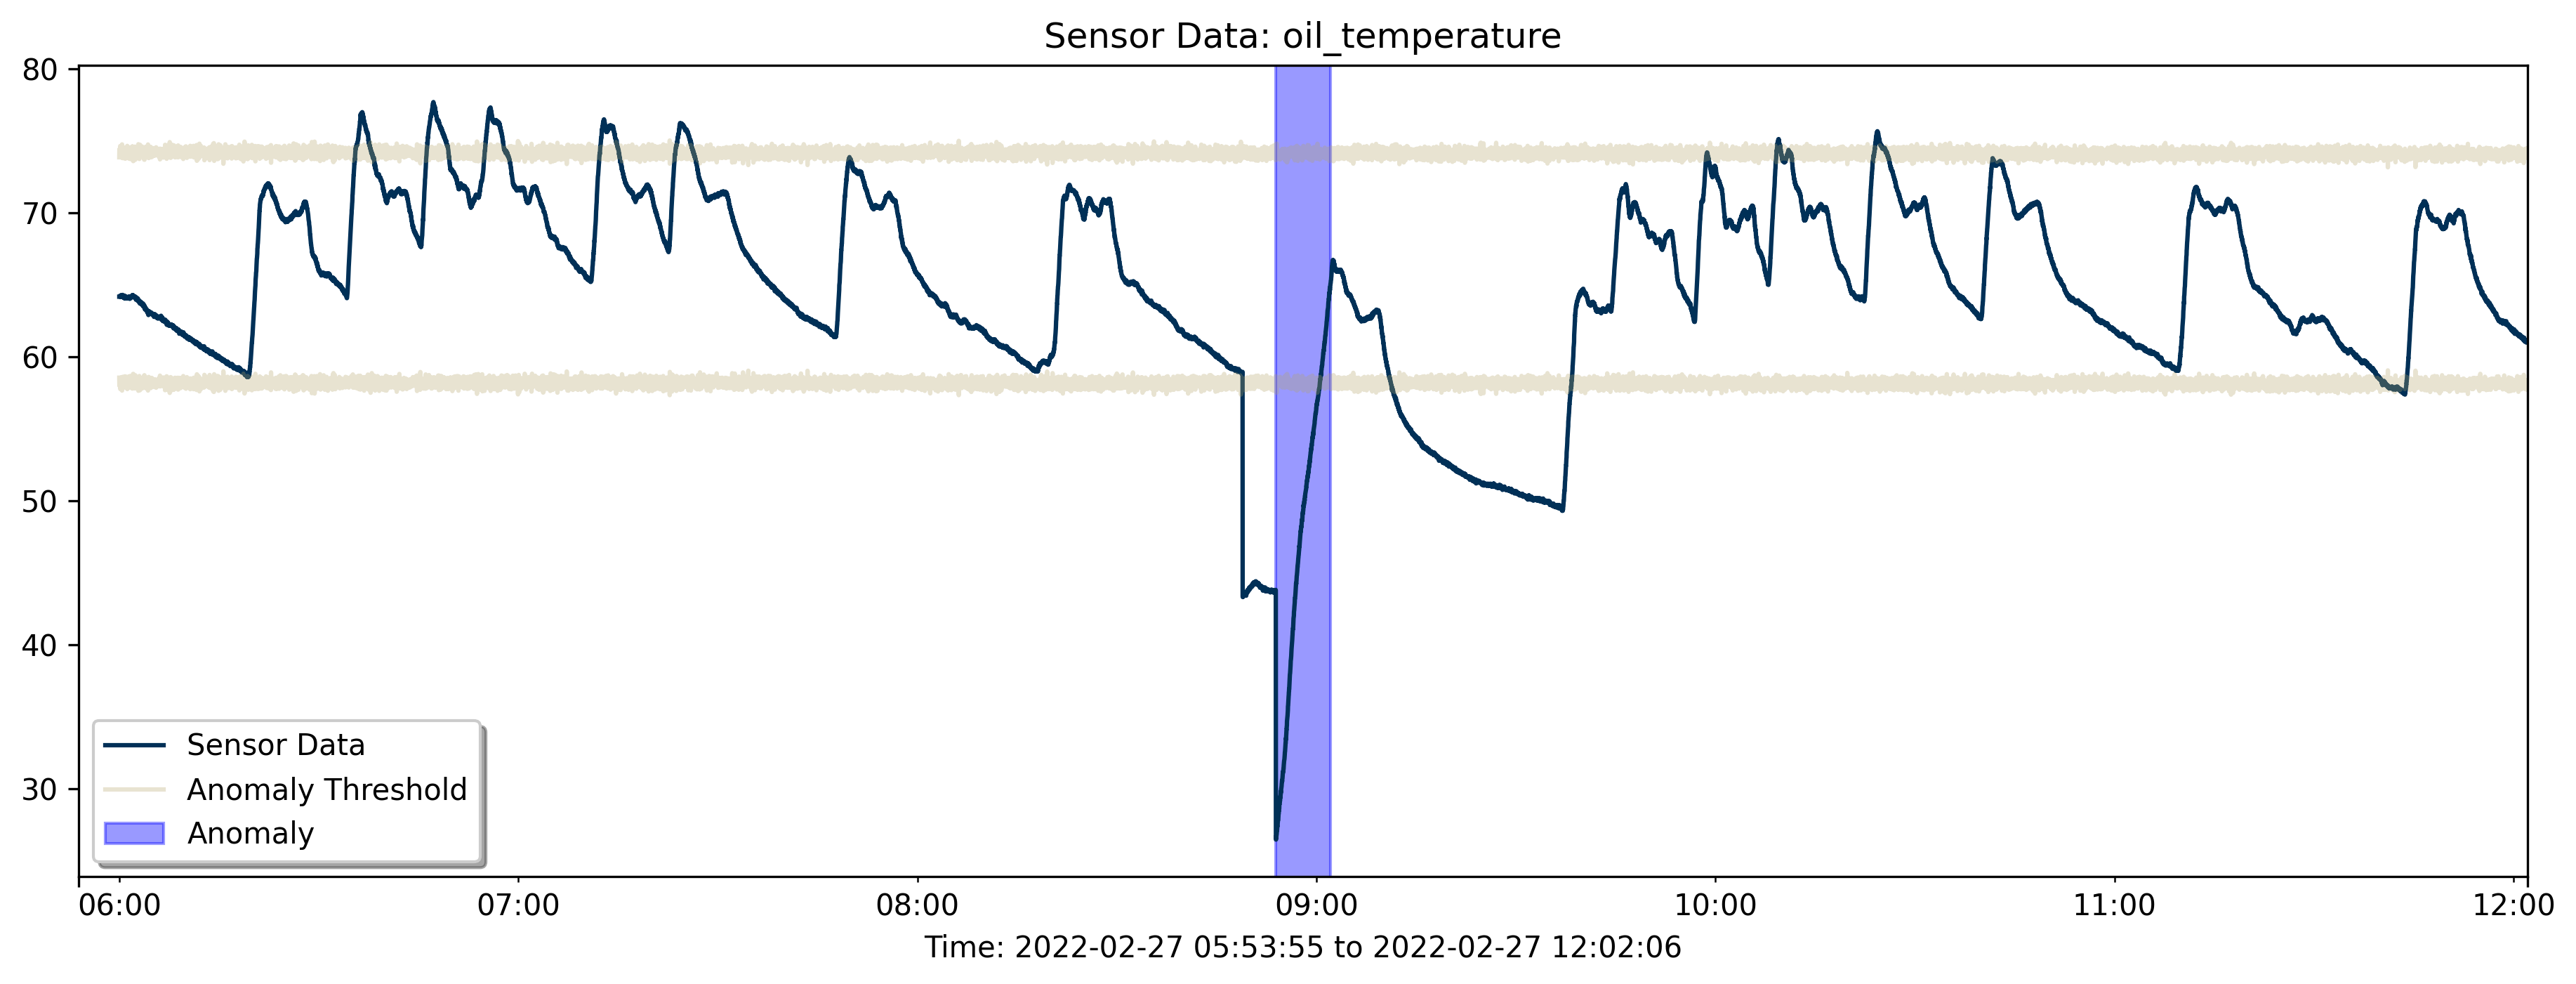

In [ ]:
display(Image(r'./output/analog_plot.png'))

In [18]:
messages = [HumanMessage(content='Can you show me what dv electric looks like around the anomaly period?')]
messages = llm_graph.invoke({'messages': messages}, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [19]:
for m in messages['messages'][-4:]:
    m.pretty_print()
    print()

================================ Human Message =================================

Can you show me what dv electric looks like around the anomaly period?

================================== Ai Message ==================================
Tool Calls:
  update_digital_sensor_plot_for_user (call_VzyMHpW4m5aC2OHDoG2J6v6V)
 Call ID: call_VzyMHpW4m5aC2OHDoG2J6v6V
  Args:
    sensor_name: dv_electric
    start_ts: 2022-02-27 05:53:55
    end_ts: 2022-02-27 12:02:06

================================= Tool Message =================================
Name: update_digital_sensor_plot_for_user

null

================================== Ai Message ==================================

I've plotted the "dv electric" digital sensor data around the time of the anomaly on February 27th. Now you can see how it behaved before, during, and after the anomaly period. If you have any more questions or need further insights, feel free to let me know!



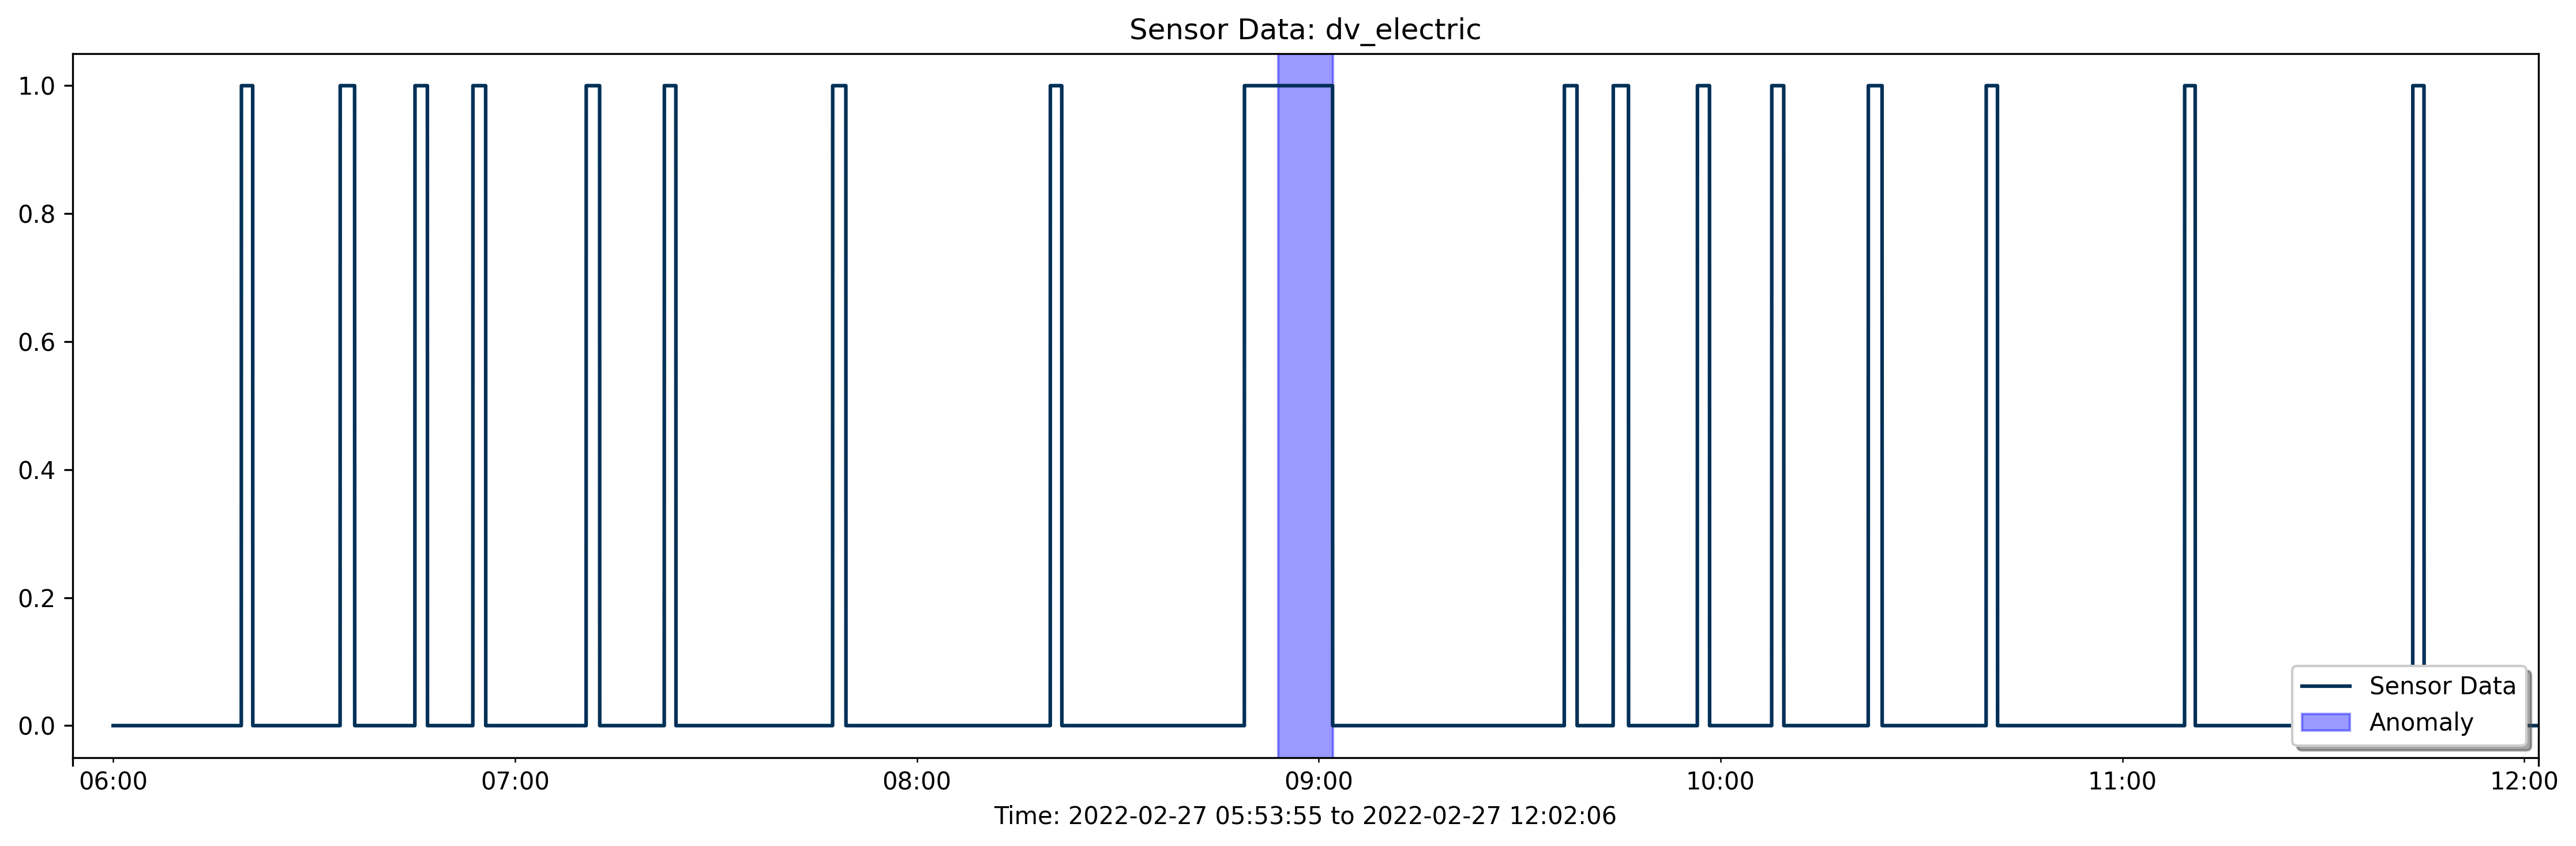

In [ ]:
display(Image(r'./output/digital_plot.png'))

In [21]:
messages = [HumanMessage(content='Can you remind me what unit oil temperature is in?')]
messages = llm_graph.invoke({'messages': messages}, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [23]:
for m in messages['messages'][-2:]:
    m.pretty_print()
    print()

================================ Human Message =================================

Can you remind me what unit oil temperature is in?

================================== Ai Message ==================================

The oil temperature is measured in degrees Celsius (°C). If you have more questions or need further assistance, feel free to ask!



In [31]:
messages['messages'][-2]

HumanMessage(content='Can you remind me what unit oil temperature is in?', additional_kwargs={}, response_metadata={}, id='203f1c0f-8086-454a-820d-f046294257c3')

In [ ]:
with open(r'./output/context.log', r'r') as f:
    log = f.readlines()

j = None
for i, line in enumerate(log):
    if messages['messages'][-2].id in line:
        j = i

if j:
    print(''.join(log[j:]))

Prompt ID: 203f1c0f-8086-454a-820d-f046294257c3
Prompt: Can you remind me what unit oil temperature is in?

Retrieved: 4, Sample (Top-1):
•	 TP34 - Pressure generated at the pneumatic panel (bar).
•	 H14 - Valve that is activated when the pressure read by the pressure switch of the command is above the oper-
ating pressure of 10.2 bar (bar).
•	 DV_pressure 4 - Pressure exerted due to pressure drop generated when air dryers towers discharge the 
water. When it is equal to zero, the compressor is working under load (bar).
•	 Reservoirs4 - Pressure inside the air tanks installed on the trains (bar).
•	 Oil_Temperature5 - Temperature of the oil present on the compressor (°C).
•	 Flowmeter6 - Airflow was measured on the pneumatic control panel (m3/h).
•	 Motor_Current 7 - Motor’s current, which should present the following values: (i) close to 0 A when the 
compressor turns off; (ii) close to 4 A when the compressor is working offloaded; and (iii) close to 7 A when 
the compressor is operat